<a href="https://colab.research.google.com/github/Suryaprasadindra/research/blob/main/v2-elbowplot_houseprice_sample_generating_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd

np.random.seed(0)  # for reproducibility

# Number of samples
n_samples = 10000

# Feature: Size (sq_ft), normally distributed around 1500 sq_ft with std deviation of 500 sq_ft
size = np.random.normal(1500, 500, n_samples).astype(int)

# Feature: Bedrooms, assuming 1-5 bedrooms, uniformly distributed
bedrooms = np.random.randint(1, 6, n_samples)

# Feature: Age of the house, normally distributed around 20 years with std deviation of 15 years
age = np.abs(np.random.normal(20, 15, n_samples)).astype(int)  # absolute to avoid negative ages

# Feature: Bathrooms, assuming 1-4 bathrooms, uniformly distributed
bathrooms = np.random.randint(1, 5, n_samples)

# Feature: Location Type
location_types = ["Urban", "Suburban", "Rural"]
location = np.random.choice(location_types, n_samples)

# Feature: Economic Condition
economic_conditions = ["Low", "Medium", "High"]
economic_condition = np.random.choice(economic_conditions, n_samples)

# Generating Price based on the features with random noise
base_price = 100  # base price in thousands of dollars
price = (base_price + (size * 0.1) + (bedrooms * 10) - (age * 2) + (bathrooms * 5) +
         np.random.normal(0, 25, n_samples))  # Random noise
# Adjust price based on location and economic condition
price *= np.where(location == "Urban", 1.1, 1)
price *= np.where(location == "Suburban", 1.05, 1)
price *= np.where(location == "Rural", 0.9, 1)
price *= np.where(economic_condition == "High", 1.2, 1)
price *= np.where(economic_condition == "Medium", 1.1, 1)
price *= np.where(economic_condition == "Low", 0.8, 1)

# Create DataFrame
data = pd.DataFrame({
    'Size': size,
    'Bedrooms': bedrooms,
    'Age': age,
    'Bathrooms': bathrooms,
    'Location Type': location,
    'Economic Condition': economic_condition,
    'Price': price
})

# Display the first few rows of the dataset
print(data.head())




   Size  Bedrooms  Age  Bathrooms Location Type Economic Condition       Price
0  2382         5    9          2         Urban                Low  323.521609
1  1700         1   27          1         Rural               High  293.909378
2  1989         5   16          1      Suburban                Low  286.181063
3  2620         2    5          2      Suburban             Medium  404.542485
4  2433         4   22          3      Suburban             Medium  438.664799


In [62]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Data loading and initial setup (assuming 'data' is your DataFrame)

# Separate the features and target variable
X = data.drop('Price', axis=1)
y = data['Price']

# Define the categorical columns and the numerical columns
categorical_cols = ['Location Type', 'Economic Condition']
numerical_cols = ['Size', 'Bedrooms', 'Age', 'Bathrooms']

# Outlier Removal using IQR for numerical columns
def remove_outliers(df, column_names):
    for col in column_names:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Applying outlier removal
X = remove_outliers(X, numerical_cols)
y = y.loc[X.index]  # Make sure to align the target variable with the filtered features

# Create a Column Transformer to apply different preprocessing to categorical and numerical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),  # Scale numerical columns
        ('cat', OneHotEncoder(drop='first'), categorical_cols)  # Encode categorical columns
    ])

# Create a preprocessing pipeline that applies the transformer
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit and transform the training data and transform the test data (if split)
X_preprocessed = pipeline.fit_transform(X)

# Convert the processed features back into a DataFrame (optional, for verification)
# Extracting feature names for the transformed columns after one-hot encoding
ohe_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out()
transformed_cols = list(numerical_cols) + list(ohe_feature_names)

# Create the new DataFrame from the array returned by the ColumnTransformer
X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=transformed_cols, index=X.index)

# Display the first few rows of the processed DataFrame
print(X_preprocessed_df.head())


       Size  Bedrooms       Age  Bathrooms  Location Type_Suburban  \
0  1.853657  1.394838 -0.905441  -0.469732                     0.0   
1  0.436039 -1.428648  0.489632  -1.363669                     0.0   
2  1.036760  1.394838 -0.362913  -1.363669                     1.0   
3  2.348368 -0.722777 -1.215457  -0.469732                     1.0   
4  1.959666  0.688967  0.102112   0.424204                     1.0   

   Location Type_Urban  Economic Condition_Low  Economic Condition_Medium  
0                  1.0                     1.0                        0.0  
1                  0.0                     0.0                        0.0  
2                  0.0                     1.0                        0.0  
3                  0.0                     0.0                        1.0  
4                  0.0                     0.0                        1.0  


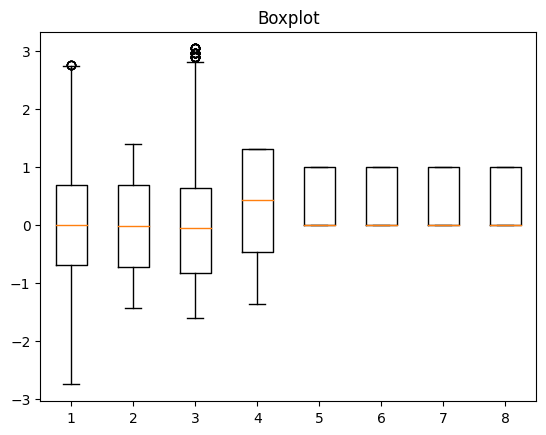

In [64]:
import matplotlib.pyplot as plt

plt.boxplot(X_preprocessed_df)
plt.title("Boxplot")
plt.show()


z score outlier

In [65]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Assuming 'data' is your DataFrame

# Separate the features and target variable
X = data.drop('Price', axis=1)
y = data['Price']

# Define the categorical and numerical columns
categorical_cols = ['Location Type', 'Economic Condition']
numerical_cols = ['Size', 'Bedrooms', 'Age', 'Bathrooms']

# Enhanced Z-score Outlier Removal
def remove_outliers_z_score(df, column_names, threshold=2.7):
    idx_to_keep = set(df.index)  # Start with all indices
    for col in column_names:
        col_zscore = np.abs(stats.zscore(df[col].dropna()))  # Calculate Z-score, excluding NaNs
        col_idx_to_keep = df[col_zscore < threshold].index
        idx_to_keep.intersection_update(col_idx_to_keep)  # Intersect with indices within the threshold

    return df.loc[list(idx_to_keep)]  # Convert set to list for proper indexing

# Apply enhanced Z-score based outlier removal
X_clean = remove_outliers_z_score(X, numerical_cols)
y_clean = y.loc[X_clean.index]  # Ensure the target variable aligns with the filtered features

# Create a Column Transformer to apply different preprocessing to categorical and numerical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),  # Scale numerical columns
        ('cat', OneHotEncoder(drop='first'), categorical_cols)  # Encode categorical columns
    ])

# Create a preprocessing pipeline that includes the preprocessor
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit and transform the training data, and prepare to transform the test data
X_preprocessed = pipeline.fit_transform(X_clean)

# Extract feature names for the transformed columns after one-hot encoding
ohe_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out()
transformed_cols = list(numerical_cols) + list(ohe_feature_names)

# Create a new DataFrame from the array returned by the ColumnTransformer
X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=transformed_cols, index=X_clean.index)

# Display the first few rows of the processed DataFrame
print(X_preprocessed_df.head())


       Size  Bedrooms       Age  Bathrooms  Location Type_Suburban  \
0  1.853957  1.395975 -0.907996  -0.469963                     0.0   
1  0.436474 -1.426631  0.511561  -1.363973                     0.0   
2  1.037138  1.395975 -0.355946  -1.363973                     1.0   
3  2.348622 -0.720979 -1.223453  -0.469963                     1.0   
4  1.959957  0.690324  0.117240   0.424047                     1.0   

   Location Type_Urban  Economic Condition_Low  Economic Condition_Medium  
0                  1.0                     1.0                        0.0  
1                  0.0                     0.0                        0.0  
2                  0.0                     1.0                        0.0  
3                  0.0                     0.0                        1.0  
4                  0.0                     0.0                        1.0  


In [66]:
X = X_preprocessed_df
X.head()

,Size,Bedrooms,Age,Bathrooms,Location Type_Suburban,Location Type_Urban,Economic Condition_Low,Economic Condition_Medium
0,1.853957,1.395975,-0.907996,-0.469963,0.0,1.0,1.0,0.0
1,0.436474,-1.426631,0.511561,-1.363973,0.0,0.0,0.0,0.0
2,1.037138,1.395975,-0.355946,-1.363973,1.0,0.0,1.0,0.0
3,2.348622,-0.720979,-1.223453,-0.469963,1.0,0.0,0.0,1.0
4,1.959957,0.690324,0.117240,0.424047,1.0,0.0,0.0,1.0


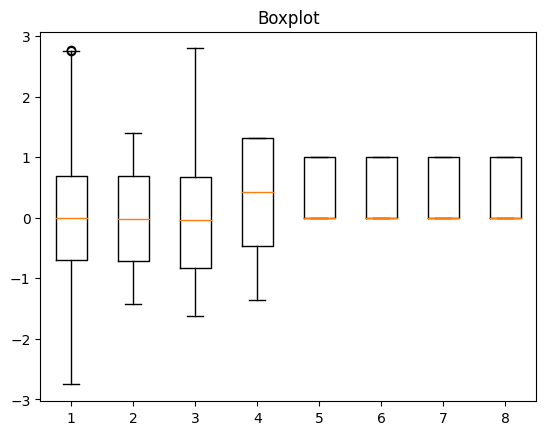

In [67]:
import matplotlib.pyplot as plt

plt.boxplot(X)
plt.title("Boxplot")
plt.show()


In [68]:
y = y_clean
y

0       323.521609
1       293.909378
2       286.181063
3       404.542485
4       438.664799
           ...    
9995    293.712742
9996    242.701058
9997    384.794084
9998    235.492341
9999    452.959512
Name: Price, Length: 9852, dtype: float64

In [69]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'X' and 'y' are your features and target variable from the loaded dataset
# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost regressor
xgb_regressor = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Train the model
xgb_regressor.fit(X_train, y_train)

# Predictions on training and testing sets
y_train_pred = xgb_regressor.predict(X_train)
y_test_pred = xgb_regressor.predict(X_test)

# Training and Testing R² scores
training_accuracy = r2_score(y_train, y_train_pred)
testing_accuracy = r2_score(y_test, y_test_pred)
print(f'Training Accuracy (R²): {training_accuracy}')
print(f'Testing Accuracy (R²): {testing_accuracy}')

# Mean Squared Error and Root Mean Squared Error for the test set
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_test_pred)
print(f'Mean Absolute Error (MAE): {mae}')

# Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(y_test, y_test_pred)
print(f'Mean Absolute Percentage Error (MAPE): {mape}')



Training Accuracy (R²): 0.8933504845085845
Testing Accuracy (R²): 0.8832242280937928
Mean Squared Error (MSE): 791.1113195275781
Root Mean Squared Error (RMSE): 28.126701184596428
Mean Absolute Error (MAE): 22.136993069462285
Mean Absolute Percentage Error (MAPE): 0.09312681763850801


k means

In [70]:
X

,Size,Bedrooms,Age,Bathrooms,Location Type_Suburban,Location Type_Urban,Economic Condition_Low,Economic Condition_Medium
0,1.853957,1.395975,-0.907996,-0.469963,0.0,1.0,1.0,0.0
1,0.436474,-1.426631,0.511561,-1.363973,0.0,0.0,0.0,0.0
2,1.037138,1.395975,-0.355946,-1.363973,1.0,0.0,1.0,0.0
3,2.348622,-0.720979,-1.223453,-0.469963,1.0,0.0,0.0,1.0
4,1.959957,0.690324,0.117240,0.424047,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
9995,-1.860183,1.395975,-1.144589,0.424047,0.0,1.0,0.0,0.0
9996,0.064436,-1.426631,0.274968,0.424047,0.0,1.0,0.0,1.0
9997,0.557022,-0.015328,-1.538910,1.318056,0.0,1.0,0.0,1.0
9998,-0.014544,-0.015328,-1.617774,1.318056,0.0,0.0,1.0,0.0


In [71]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, r2_score
import numpy as np

# Assuming 'X' and 'y' are your features and target variable from the loaded dataset

# Step 1: Apply K-means clustering
num_clusters = 2  # Define the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(X)

# Step 2: Create training and testing datasets
X_train_list = []
y_train_list = []
X_test_list = []
y_test_list = []

for i in range(num_clusters):
    X_cluster = X[clusters == i]
    y_cluster = y[clusters == i]
    X_train, X_test, y_train, y_test = train_test_split(X_cluster, y_cluster, test_size=0.2, random_state=42)
    X_train_list.append(X_train)
    y_train_list.append(y_train)
    X_test_list.append(X_test)
    y_test_list.append(y_test)

# Combine the cluster splits into single training and testing sets
X_train = pd.concat(X_train_list)
y_train = pd.concat(y_train_list)
X_test = pd.concat(X_test_list)
y_test = pd.concat(y_test_list)

# Step 3: Apply XGBoost
xgb_regressor = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xgb_regressor.fit(X_train, y_train)
y_train_pred = xgb_regressor.predict(X_train)
y_test_pred = xgb_regressor.predict(X_test)

# Step 4: Calculate Metrics
training_accuracy = r2_score(y_train, y_train_pred)
testing_accuracy = r2_score(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)  # Calculating Mean Absolute Error

# Print the results
print(f'Training Accuracy (R²): {training_accuracy}')
print(f'Testing Accuracy (R²): {testing_accuracy}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}')
print(f'Mean Absolute Error (MAE): {mae}')  # Displaying the Mean Absolute Error


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Training Accuracy (R²): 0.8935926697496946
Testing Accuracy (R²): 0.8862643314206728
Mean Squared Error (MSE): 751.0638506344939
Root Mean Squared Error (RMSE): 27.405544158700696
Mean Absolute Percentage Error (MAPE): 0.08877158759731221
Mean Absolute Error (MAE): 21.507903625515027


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

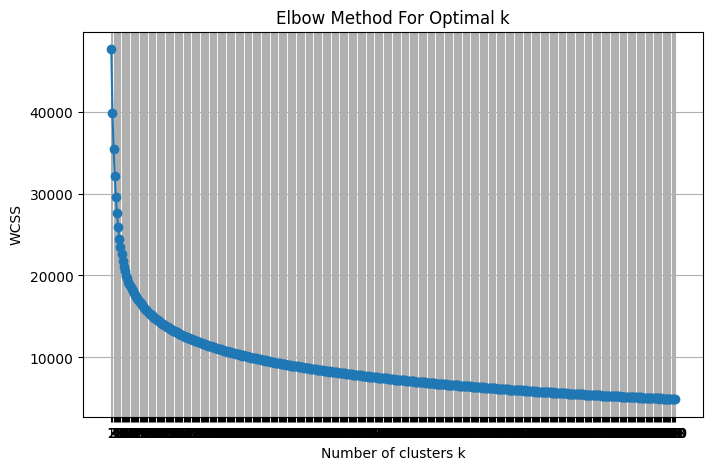

In [58]:
# Define a range for the number of clusters we want to test
k_values = range(1, 501)

# Compute the within-cluster sum of squares for each number of clusters
wcss = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)




In [80]:
import matplotlib.pyplot as plt

# Assume wcss is your list of WCSS values for the range of k values
# Your list of WCSS values

# Set the range for the k values you have computed (for example, 1 to 10)
k_values = range(1, len(wcss) + 1)

# Plotting the elbow plot with increased figure size and customized ticks
plt.figure(figsize=(200, 200))  # Increase the figure size
plt.plot(k_values, wcss, 'bx-')  # Plot WCSS against the number of clusters k
plt.xlabel('Number of clusters k')  # Label for the x-axis
plt.ylabel('WCSS')  # Label for the y-axis
plt.title('Elbow Method For Optimal k')  # Title of the plot
plt.xticks(k_values, rotation=90)  # This ensures every k value is used as a tick on the x-axis
plt.show()  # Display the plot


In [88]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, r2_score
import numpy as np

# Load your dataset
# X = ... (Your features)
# y = ... (Your target variable)

# Define a range of k values to evaluate
k_values = [490]
# Initialize a dictionary to store the results
results = {}

# Loop over each k value
for k in k_values:
    # Apply K-means clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(X)

    # Create training and testing datasets
    X_train_list = []
    y_train_list = []
    X_test_list = []
    y_test_list = []

    for i in range(k):
        X_cluster = X[clusters == i]
        y_cluster = y[clusters == i]
        X_train, X_test, y_train, y_test = train_test_split(X_cluster, y_cluster, test_size=0.2, random_state=42)
        X_train_list.append(X_train)
        y_train_list.append(y_train)
        X_test_list.append(X_test)
        y_test_list.append(y_test)

    # Combine the cluster splits into single training and testing sets
    X_train = pd.concat(X_train_list)
    y_train = pd.concat(y_train_list)
    X_test = pd.concat(X_test_list)
    y_test = pd.concat(y_test_list)

    # Apply XGBoost
    xgb_regressor = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    xgb_regressor.fit(X_train, y_train)
    y_train_pred = xgb_regressor.predict(X_train)
    y_test_pred = xgb_regressor.predict(X_test)

    # Calculate Metrics
    training_accuracy = r2_score(y_train, y_train_pred)
    testing_accuracy = r2_score(y_test, y_test_pred)
    mse = mean_squared_error(y_test, y_test_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, y_test_pred)
    mae = mean_absolute_error(y_test, y_test_pred)

    # Store results
    results[k] = {
        'Training Accuracy (R²)': training_accuracy,
        'Testing Accuracy (R²)': testing_accuracy,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape,
        'MAE': mae
    }

# Output the results for all k values
for k, metrics in results.items():
    print(f"Results for k={k}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")
    print()  # Add an empty line for better readability between each k's results


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Results for k=490:
Training Accuracy (R²): 0.8936062899072549
Testing Accuracy (R²): 0.8830787118195534
MSE: 744.3330693686003
RMSE: 27.282468168562026
MAPE: 0.0892859356232842
MAE: 21.199684571595263

